In [7]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [8]:
# Dataset path
data_path = "../data/secondary_data.csv"

# Load dataset with correct delimiter
df = pd.read_csv(data_path, sep=";")

# Basic checks
df.head(), df.shape



(  class  cap-diameter cap-shape cap-surface cap-color does-bruise-or-bleed  \
 0     p         15.26         x           g         o                    f   
 1     p         16.60         x           g         o                    f   
 2     p         14.07         x           g         o                    f   
 3     p         14.17         f           h         e                    f   
 4     p         14.64         x           h         o                    f   
 
   gill-attachment gill-spacing gill-color  stem-height  ...  stem-root  \
 0               e          NaN          w        16.95  ...          s   
 1               e          NaN          w        17.99  ...          s   
 2               e          NaN          w        17.80  ...          s   
 3               e          NaN          w        15.77  ...          s   
 4               e          NaN          w        16.53  ...          s   
 
   stem-surface stem-color veil-type veil-color has-ring ring-type  \
 0

In [9]:
# Target and features
target_col = "class"
y = df[target_col]
X = df.drop(columns=[target_col])

# Class distribution
y.value_counts(), y.value_counts(normalize=True)


(class
 p    33888
 e    27181
 Name: count, dtype: int64,
 class
 p    0.554913
 e    0.445087
 Name: proportion, dtype: float64)

In [10]:
# Missing value analysis
missing_counts = X.isna().sum()
missing_ratio = (missing_counts / len(X)).sort_values(ascending=False)

missing_counts[missing_counts > 0], missing_ratio[missing_ratio > 0]


(cap-surface          14120
 gill-attachment       9884
 gill-spacing         25063
 stem-root            51538
 stem-surface         38124
 veil-type            57892
 veil-color           53656
 ring-type             2471
 spore-print-color    54715
 dtype: int64,
 veil-type            0.947977
 spore-print-color    0.895954
 veil-color           0.878613
 stem-root            0.843931
 stem-surface         0.624277
 gill-spacing         0.410405
 cap-surface          0.231214
 gill-attachment      0.161850
 ring-type            0.040462
 dtype: float64)

In [11]:
# Feature type separation
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

len(categorical_cols), len(numeric_cols), categorical_cols, numeric_cols


(17,
 3,
 ['cap-shape',
  'cap-surface',
  'cap-color',
  'does-bruise-or-bleed',
  'gill-attachment',
  'gill-spacing',
  'gill-color',
  'stem-root',
  'stem-surface',
  'stem-color',
  'veil-type',
  'veil-color',
  'has-ring',
  'ring-type',
  'spore-print-color',
  'habitat',
  'season'],
 ['cap-diameter', 'stem-height', 'stem-width'])

In [12]:
from sklearn.impute import SimpleImputer

# Preprocessing for categorical features
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]
)

# Preprocessing for numeric features
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]
)

# Combine preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_cols),
        ("num", numeric_transformer, numeric_cols)
    ]
)

preprocessor


ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['cap-shape', 'cap-surface', 'cap-color',
                                  'does-bruise-or-bleed', 'gill-attachment',
                                  'gill-spacing', 'gill-color', 'stem-root',
                                  'stem-surface', 'stem-color', 'veil-type',
                                  'veil-color', 'has-ring', 'ring-type',
                                  'spore-print-color', 'habitat', 'season']),
                                ('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['cap-diameter', 'stem-height',
                                  'stem-width'])])

In [13]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Baseline model with most frequent strategy
baseline_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", DummyClassifier(strategy="most_frequent"))
    ]
)

# Train baseline
baseline_model.fit(X_train, y_train)

# Predictions
y_pred_baseline = baseline_model.predict(X_test)

# Metrics
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
baseline_f1 = f1_score(y_test, y_pred_baseline, pos_label="p")

baseline_accuracy, baseline_f1


(0.5549369575896512, 0.7137742207245156)

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Logistic Regression pipeline
logreg_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(
            max_iter=1000,
            class_weight="balanced",
            random_state=42
        ))
    ]
)

# Train
logreg_model.fit(X_train, y_train)

# Predict
y_pred_logreg = logreg_model.predict(X_test)

# Metrics
logreg_accuracy = accuracy_score(y_test, y_pred_logreg)
logreg_precision = precision_score(y_test, y_pred_logreg, pos_label="p")
logreg_recall = recall_score(y_test, y_pred_logreg, pos_label="p")
logreg_f1 = f1_score(y_test, y_pred_logreg, pos_label="p")

logreg_accuracy, logreg_precision, logreg_recall, logreg_f1



(0.8445226788930735, 0.8836295014939456, 0.8290056063735616, 0.85544644896095)

In [15]:
X=df.drop(columns=[target_col])
y=df[target_col].map({"p":1,"e":0})

In [16]:
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(exclude=['object']).columns.tolist()

print(f"Toplam Özellik Sayısı: {X.shape[1]}")

Toplam Özellik Sayısı: 20


In [17]:
categorical_transformer=Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="constant",fill_value="missing_value")),
    ("onehot",OneHotEncoder(handle_unknown="ignore",sparse_output=False))
])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [19]:
from sklearn.ensemble import RandomForestClassifier

print("Hyperparameter Tuning Başlıyor... (Tüm sütunlarla)")

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

Hyperparameter Tuning Başlıyor... (Tüm sütunlarla)


In [20]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5]
}

grid_search = GridSearchCV(rf_pipeline, param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print(f"En İyi Parametreler: {best_params}")
print(f"En İyi CV Skoru (F1): {grid_search.best_score_:.4f}")

Fitting 3 folds for each of 12 candidates, totalling 36 fits
En İyi Parametreler: {'classifier__max_depth': 20, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}
En İyi CV Skoru (F1): 1.0000


In [21]:
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Metrikler
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\nRandom Forest (Tuned) Accuracy: {acc:.4f}")
print(f"Random Forest (Tuned) F1 Score: {f1:.4f}")


Random Forest (Tuned) Accuracy: 0.9999
Random Forest (Tuned) F1 Score: 0.9999


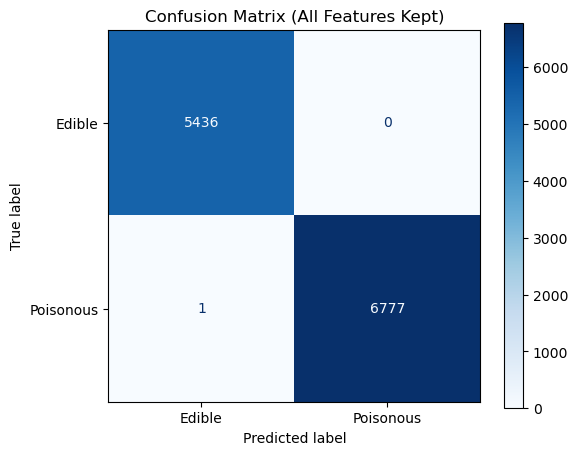

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap='Blues', display_labels=['Edible', 'Poisonous'])
ax.set_title("Confusion Matrix (All Features Kept)")
plt.savefig('confusion_matrix_final.png')

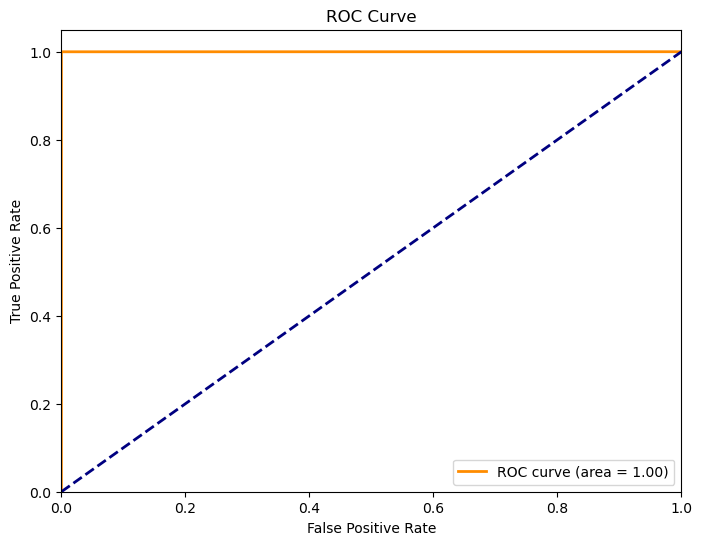

In [23]:
from sklearn.metrics import roc_curve,auc

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig('roc_curve_final.png')

In [24]:
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])
lr_pipeline.fit(X_train, y_train)
lr_acc = accuracy_score(y_test, lr_pipeline.predict(X_test))

print(f"\n--- KARŞILAŞTIRMA ---")
print(f"Logistic Regression Accuracy: {lr_acc:.4f}")
print(f"Random Forest Accuracy: {acc:.4f}")


--- KARŞILAŞTIRMA ---
Logistic Regression Accuracy: 0.8683
Random Forest Accuracy: 0.9999


Grafik kaydedildi: feature_importance_final.png


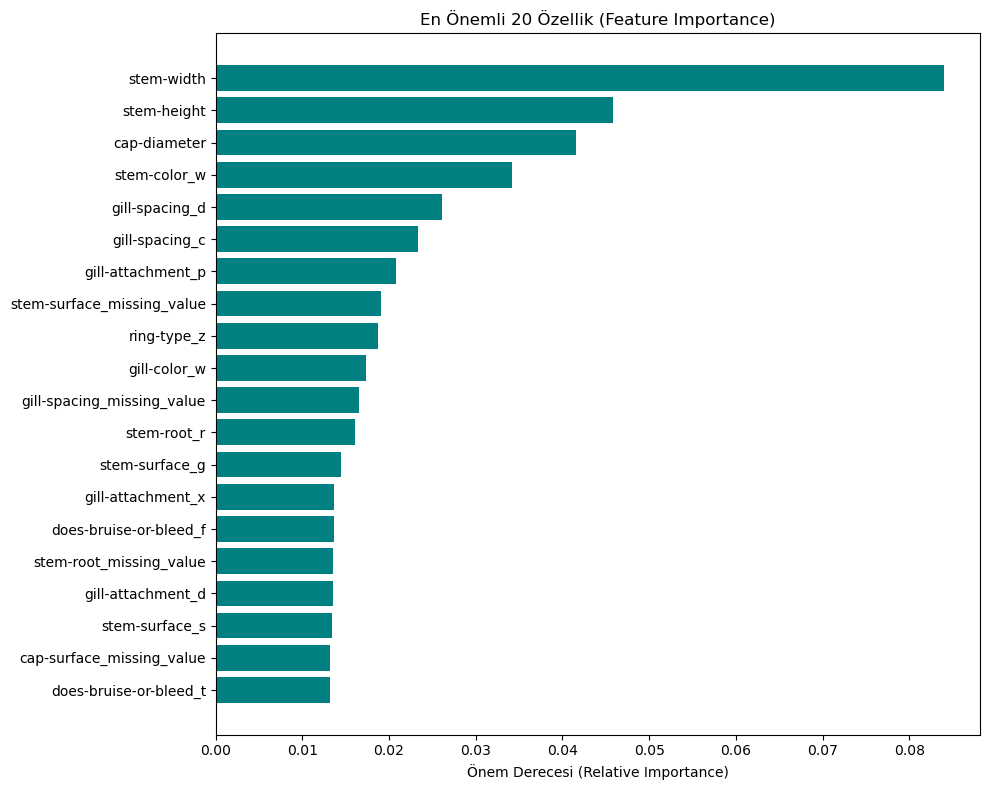

In [25]:
# Modelden özellik önem derecelerini çekelim
importances = best_model.named_steps['classifier'].feature_importances_

# Özellik isimlerini Preprocessor'dan alalım
# (Kategorik veriler one-hot yapıldığı için isimleri değişti, onları düzeltiyoruz)
ohe = best_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
cat_feature_names = ohe.get_feature_names_out(categorical_cols)
all_feature_names = np.r_[numeric_cols, cat_feature_names]

# Sıralama yapıp En Önemli 20 Özelliği alalım
indices = np.argsort(importances)[-20:]

plt.figure(figsize=(10, 8))
plt.title("En Önemli 20 Özellik (Feature Importance)")
plt.barh(range(len(indices)), importances[indices], color='teal', align="center")
plt.yticks(range(len(indices)), [all_feature_names[i] for i in indices])
plt.xlabel("Önem Derecesi (Relative Importance)")
plt.tight_layout()

# Kaydet
plt.savefig('feature_importance_final.png')
print("Grafik kaydedildi: feature_importance_final.png")